# NVIDIA RAPIDS on Azure ML
## MLADS Fall'19

The notebook lopoks at various features of the NY taxi dataset. Processing is done one a single GPU

**AUTHORS**
* Tom Drabas (Microsoft)
* Brad Rees (NVIDIA)
* John Zedlewski (NVIDIA)
* Paul Mahler (NVIDIA)
* Nick Becker
* Chau Dang (NVIDIA)

**GREATER TEAM**
* Joshua Patterson (NVIDIA)
* Keith Kraus (NVIDIA)
* Michael Beaumont (NVIDIA)
* Manuel Reyes Gomez (NVIDIA)


In [1]:
# Let's first look at the available hardware - The amount og GPU memeory wil affect how much data we can process
!nvidia-smi

Sun Nov 17 05:03:04 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Graphics Device     Off  | 00000000:01:00.0 Off |                  N/A |
| 41%   45C    P0    96W / 280W |      0MiB / 24187MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# Load the required modules
import time

import cudf
import cuml
from cuml.preprocessing.model_selection import train_test_split as cumlTTS
from cuml.metrics.regression import r2_score as cuml_r2

import xgboost as xgb

import numpy as np
from collections import OrderedDict

## Read in the data

In [4]:
data_dir = '../../../'     #### REPLACE WITH THE DATA STORE PATH
data_path = os.path.join(data_dir, "data/nyctaxi/2016/")

datafiles = [
      'yellow_tripdata_2016-01.csv'
    , 'yellow_tripdata_2016-02.csv'
    , 'yellow_tripdata_2016-03.csv'
    , 'yellow_tripdata_2016-04.csv'
]

datafiles = [os.path.join(data_path, f) for f in datafiles]
first_dataset = datafiles[0]

In [5]:
%%bash -s "$first_dataset"
head -n 1 $1

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount


In [6]:
# I don't really like those column names, let me define my own
# also, by specifying the data types we can reduce read times and memory 
columns_dtypes = OrderedDict(
    [
        ('vendor_id', 'int32'),
        ('pickup_datetime', 'date'),
        ('dropoff_datetime', 'date'),
        ('passenger_count', 'int32'),
        ('trip_distance', 'int32'),
        ('pickup_longitude', 'float64'),
        ('pickup_latitude', 'float64'),
        ('rate_code', 'int32'),
        ('store_and_fwd_flag', 'int32'),
        ('dropoff_longitude', 'float64'),
        ('dropoff_latitude', 'float64'),
        ('payment_type', 'int32'),
        ('fare_amount', 'float64'),
        ('extra', 'float64'),
        ('mta_tax', 'float64'),
        ('tip_amount', 'float64'),
        ('tolls_amount', 'float64'),
        ('surcharge', 'float64'),
        ('total_amount', 'float64')
    ]
)

# don't want to use all columns, specifiy just a few
use_col  = [
    'pickup_datetime',
    'dropoff_datetime',
    'passenger_count', 
    'trip_distance',
    'pickup_longitude',
    'pickup_latitude',     
    'rate_code',
    'dropoff_longitude',
    'dropoff_latitude',    
    'fare_amount',
    'extra',
    'tip_amount',
    'total_amount'
]

In [7]:
%%time
# Load the data
data = []

for f in datafiles:
    data.append(
        cudf.read_csv(
              f
            , names=list(columns_dtypes.keys())
            , dtype=list(columns_dtypes.values())
            , skip_rows=1
            , usecols=use_col
        )
    )
    
taxi_df = cudf.concat(data)
del data   ### CLEAN UP 

CPU times: user 4.88 s, sys: 1.44 s, total: 6.32 s
Wall time: 6.32 s


In [8]:
# let's peek at the first few records
taxi_df.head(2)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,extra,tip_amount,total_amount
0,1969-12-31 23:59:59.999,1969-12-31 23:59:59.999,1000,13001012,7.027659e+15,7.027659e+14,100,5.930090e+16,5.930090e+15,inf,NaN,7.439258e+10,7.503553e+12
1,2016-01-01 00:00:00.000,2016-01-01 00:00:00.000,2,1,-7.399037e+01,4.073470e+01,1,-7.398184e+01,4.073241e+01,7.5,0.5,0.000000e+00,8.800000e+00


## Remove bad data

In [9]:
# How much data was loaded?
print(f'Raw number of rows: {len(taxi_df):,}')

Raw number of rows: 46,434,201


In [10]:
%%time
# filter out records with missing or outlier values
query_frags = ("(fare_amount > 0 and fare_amount < 500) " +
        "and (passenger_count > 0 and passenger_count < 6) " +
        "and (pickup_longitude > -75 and pickup_longitude < -73) " +
        "and (dropoff_longitude > -75 and dropoff_longitude < -73) " +
        "and (pickup_latitude > 40 and pickup_latitude < 42) " +
        "and (dropoff_latitude > 40 and dropoff_latitude < 42)"
    )

taxi_df = taxi_df.query(query_frags)

CPU times: user 200 ms, sys: 98.8 ms, total: 299 ms
Wall time: 303 ms


In [11]:
# How much data (records) were loaded?
print(f'Filtered number of rows: {len(taxi_df):,}')

Filtered number of rows: 44,104,601


## Now add some additional fields 

In [12]:
%%time
# expand the datetime into individual fields
import datetime as dt

taxi_df['hour'] = taxi_df['pickup_datetime'].dt.hour
taxi_df['year'] = taxi_df['pickup_datetime'].dt.year
taxi_df['month'] = taxi_df['pickup_datetime'].dt.month
taxi_df['day'] = taxi_df['pickup_datetime'].dt.day
taxi_df['diff'] = taxi_df['dropoff_datetime'].astype('int32') - taxi_df['pickup_datetime'].astype('int32')

# drop the original datetime fields
taxi_df = taxi_df.drop(['pickup_datetime','dropoff_datetime'])

CPU times: user 187 ms, sys: 208 ms, total: 395 ms
Wall time: 394 ms


In [13]:
%%time
# create a 'day of week' field
import math

def day_of_the_week(day, month, year, day_of_week):
    for i, (d_1, m_1, y_1) in enumerate(zip(day, month, year)):
        if month[i] < 3:
            shift = month[i]
        else:
            shift = 0
        Y = year[i] - (month[i] < 3)
        y = Y - 2000
        c = 20
        d = day[i]
        m = month[i] + shift + 1
        day_of_week[i] = (d + math.floor(m * 2.6) + y + (y // 4) + (c // 4) - 2 * c) % 7
        
taxi_df = taxi_df.apply_rows(day_of_the_week,
                   incols=['day', 'month', 'year'],
                   outcols=dict(day_of_week=np.float32),
                   kwargs=dict())

CPU times: user 385 ms, sys: 237 ms, total: 622 ms
Wall time: 621 ms


In [14]:
# let's fix the location data
taxi_df['pickup_latitude_r'] = taxi_df['pickup_latitude'] // .01 * .01
taxi_df['pickup_longitude_r'] = taxi_df['pickup_longitude'] // .01 * .01
taxi_df['dropoff_latitude_r'] = taxi_df['dropoff_latitude'] // .01 * .01
taxi_df['dropoff_longitude_r'] = taxi_df['dropoff_longitude'] // .01 * .01

In [15]:
%%time
# Compute the Haversince distance between locations
from math import cos, sin, asin, sqrt, pi

def haversine_distance_kernel(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, h_distance):
    for i, (x_1, y_1, x_2, y_2) in enumerate(zip(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude)):
        x_1 = pi / 180 * x_1
        y_1 = pi / 180 * y_1
        x_2 = pi / 180 * x_2
        y_2 = pi / 180 * y_2
        
        dlon = y_2 - y_1
        dlat = x_2 - x_1
        a = sin(dlat / 2)**2 + cos(x_1) * cos(x_2) * sin(dlon / 2)**2
        
        c = 2 * asin(sqrt(a)) 
        r = 6371 # Radius of earth in kilometers
        
        h_distance[i] = c * r
        
taxi_df = taxi_df.apply_rows(haversine_distance_kernel,
                   incols=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
                   outcols=dict(h_distance=np.float32),
                   kwargs=dict())

CPU times: user 469 ms, sys: 216 ms, total: 685 ms
Wall time: 689 ms


---
## Now let's do some data science

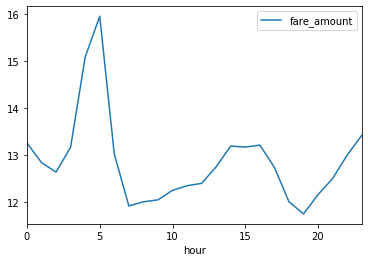

In [16]:
%matplotlib inline
taxi_df.groupby('hour').fare_amount.mean().to_pandas().sort_index().plot(legend=True)

In [17]:
X_train, X_test, y_train, y_test = cumlTTS(taxi_df, 'fare_amount', train_size=0.75)

# Create a DMatrix
dtrain = xgb.DMatrix(X_train, y_train)
del taxi_df

In [18]:
%%time
# Train XGBoost
params = {
    'learning_rate'  : 0.3,
    'max_depth'      : 8,
    'objective'      : 'reg:squarederror',
    'subsample'      : 0.6,
    'gamma'          : 1,
    'silent'         : True,
    'verbose_eval'   : True,
    'tree_method'    :'gpu_hist'
}


trained_model = xgb.train(params, dtrain)

CPU times: user 5.76 s, sys: 2.48 s, total: 8.23 s
Wall time: 8.24 s


# Test the model

In [19]:
dtest = xgb.DMatrix(X_test, y_test)
y_hat = trained_model.predict(dtest).astype('float64')
print('R^2 of the model: {0:.4f}'.format(cuml_r2(y_test, y_hat)))

R^2 of the model: 0.9849
